<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Before we begin.. after reading the description.txt

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
house.shape

(1460, 81)

In [5]:
#Check Cols and check Descr to see for anything missing
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [6]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
#Check Null value cols
house.columns[house.isna().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [8]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [9]:
#Check LotFrontage first - Desc: LotFrontage: Linear feet of street connected to property
house[house['LotFrontage'].isnull()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000


In [10]:
house[house['LotFrontage'] == 0]
### SHALL REPLACE NaN with 0 ###

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [11]:
## NEXT: Check Alley - Desc: 
# Alley: Type of alley access to property
#
#       Grvl	Gravel
#       Pave	Paved
#       NA 	No alley access

house.Alley.value_counts() ## This means i should have house.shape (1460,81) : 1460 - 91 = 1396 NaNs for Alley.

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [12]:
## 1396 Check.
house.Alley.isnull().sum()

1369

### Getting suspicious about NA..

In [13]:
## Check MasVnrType for None as NA? 
# MasVnrType: Masonry veneer type
#
#       BrkCmn	Brick Common
#       BrkFace	Brick Face
#       CBlock	Cinder Block
#       None	None
#       Stone	Stone

In [14]:
house.MasVnrType.value_counts() ## This means i should have house.shape (1460,81) : 1460 - 1452 = 8 NaNs for None.

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [15]:
house[house['MasVnrType'].isnull()].loc[:, 'MasVnrType':] #Just see the col slice, if not it wont display

,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


In [16]:
house.MasVnrType.isnull().sum()
## 8 Check.. but that was for 'None' but not explicitly 'NA'

8

In [17]:
## LAST CHECK for NA.

# BsmtQual: Evaluates the height of the basement
#
#       Ex	Excellent (100+ inches)	
#       Gd	Good (90-99 inches)
#       TA	Typical (80-89 inches)
#       Fa	Fair (70-79 inches)
#       Po	Poor (<70 inches
#       NA	No Basement

In [18]:
house.BsmtQual.value_counts() ## No 'Po'

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [19]:
## Check to see who has 'Po' basement with BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1
house[(house['BsmtQual'] == 'Po') | \
      (house['BsmtCond'] == 'Po') | \
      (house['BsmtExposure'] == 'Po') | \
      (house['BsmtFinType1'] == 'Po')].loc[:, 'BsmtQual':] #Just see the col slice, if not it wont display

## The rows with 'Po' has no NaNs for the basement features.

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
375,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,61000
398,Fa,Po,No,Unf,0,Unf,0,961,961,GasA,...,0,NaN,NaN,NaN,0,11,2007,WD,Abnorml,67000


In [20]:
## So.. BsmtQual has 1460 - 1423 = 37 NaNs
house.BsmtQual.isnull().sum()
# Check on 37.

37

## NaNs replace 'NA's in the cols. (Many cols affected) Not good. Restart.


<p>From pandas read_csv</p>
<p><strong>na_values</strong>&nbsp;: scalar, str, list-like, or dict, default None</p>
<blockquote>
<div>
<p>Additional strings to recognize as NA/NaN. If dict passed, specific per-column NA values. By default the following values are interpreted as NaN: &lsquo;&rsquo;, &lsquo;#N/A&rsquo;, &lsquo;#N/A N/A&rsquo;, &lsquo;#NA&rsquo;, &lsquo;-1.#IND&rsquo;, &lsquo;-1.#QNAN&rsquo;, &lsquo;-NaN&rsquo;, &lsquo;-nan&rsquo;, &lsquo;1.#IND&rsquo;, &lsquo;1.#QNAN&rsquo;, &lsquo;N/A&rsquo;, &lsquo;<span style="background-color: #00ff00;">NA</span>&rsquo;, &lsquo;NULL&rsquo;, &lsquo;NaN&rsquo;, &lsquo;n/a&rsquo;, &lsquo;nan&rsquo;, &lsquo;null&rsquo;.</p>
</div>
</blockquote>
<p><strong>keep_default_na</strong>&nbsp;: bool, default True</p>
<blockquote>
<div>
<p>Whether or not to include the default NaN values when parsing the data. Depending on whether&nbsp;<cite>na_values</cite>&nbsp;is passed in, the behavior is as follows:</p>
<ul class="simple">
<li>If&nbsp;<cite>keep_default_na</cite>&nbsp;is True, and&nbsp;<cite>na_values</cite>&nbsp;are specified,&nbsp;<cite>na_values</cite>&nbsp;is appended to the default NaN values used for parsing.</li>
<li>If&nbsp;<cite>keep_default_na</cite>&nbsp;is True, and&nbsp;<cite>na_values</cite>&nbsp;are not specified, only the default NaN values are used for parsing.</li>
<li>If&nbsp;<cite>keep_default_na</cite>&nbsp;is False, and&nbsp;<cite>na_values</cite>&nbsp;are specified, only the NaN values specified&nbsp;<cite>na_values</cite>&nbsp;are used for parsing.</li>
<li><span style="background-color: #00ff00;">If&nbsp;<cite>keep_default_na</cite>&nbsp;is False, and&nbsp;<cite>na_values</cite>&nbsp;are not specified, no strings will be parsed as NaN.</span></li>
</ul>
<p>Note that if&nbsp;<cite>na_filter</cite>&nbsp;is passed in as False, the&nbsp;<cite>keep_default_na</cite>&nbsp;and&nbsp;<cite>na_values</cite>&nbsp;parameters will be ignored.</p>
</div>
</blockquote>

### NAs should be kept because they represent binary 0. It should not represent 'no information'

In [21]:
house2 = pd.read_csv('./housing.csv', keep_default_na=False)

In [22]:
## Lets double check on Alley's 'NA' -> Id == 1
house[house['Id'] == 1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [23]:
house2[house2['Id'] == 1]
## Success!

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500


In [24]:
house2.columns[house2.isna().any()].tolist()
## No NaNs in the DF. ^_^

[]

In [25]:
#house2.isnull().sum()

In [26]:
#Original Shape: (1460, 81)
house2.shape
## Good that theres no diff.

(1460, 81)

In [27]:
house2.dtypes.value_counts()

object    46
int64     35
dtype: int64

In [28]:
house2.select_dtypes(include=['int']).head(10)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000
5,6,50,14115,5,5,1993,1995,732,0,64,...,40,30,0,320,0,0,700,10,2009,143000
6,7,20,10084,8,5,2004,2005,1369,0,317,...,255,57,0,0,0,0,0,8,2007,307000
7,8,60,10382,7,6,1973,1973,859,32,216,...,235,204,228,0,0,0,350,11,2009,200000
8,9,50,6120,7,5,1931,1950,0,0,952,...,90,0,205,0,0,0,0,4,2008,129900
9,10,190,7420,5,6,1939,1950,851,0,140,...,0,4,0,0,0,0,0,1,2008,118000


## Feature Engineering/Cleaning/Correcting - Converting values into categories.

In [29]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	

#         20	1-STORY 1946 & NEWER ALL STYLES
#         30	1-STORY 1945 & OLDER
#         40	1-STORY W/FINISHED ATTIC ALL AGES
#         45	1-1/2 STORY - UNFINISHED ALL AGES
#         50	1-1/2 STORY FINISHED ALL AGES
#         60	2-STORY 1946 & NEWER
#         70	2-STORY 1945 & OLDER
#         75	2-1/2 STORY ALL AGES
#         80	SPLIT OR MULTI-LEVEL
#         85	SPLIT FOYER
#         90	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

# MSSubClass is a Category. Should not be integer

house2.MSSubClass = house2.MSSubClass.astype('str')

In [30]:
## LotFrontage: Linear feet of street connected to property
## Replace NAs with 0

house2.LotFrontage = house2.LotFrontage.apply(lambda x: 0 if x=='NA' else x)

In [31]:
house2.LotFrontage = house2.LotFrontage.astype('int')

In [32]:
# OverallQual: Rates the overall material and finish of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average
#        5	Average
#        4	Below Average
#        3	Fair
#        2	Poor
#        1	Very Poor
	
# OverallCond: Rates the overall condition of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average	
#        5	Average
#        4	Below Average	
#        3	Fair
#        2	Poor
#        1	Very Poor

## Both are Categorical.
## Convert to Str

## MAYBE SHOULD LEAVE IT. COZ ITS A 'RANK' . Lets see what happens.
## DECIDED NOT TO CONVERT.
# house2.OverallQual = house2.OverallQual.astype('str')
# house2.OverallCond = house2.OverallCond.astype('str')

In [33]:
# MoSold: Month Sold (MM)
# YrSold: Year Sold (YYYY)

## Both are Categorical. Dates should not be values.
## Convert to Str

## MAYBE SHOULD LEAVE IT. COZ ITS A 'RANK' . Lets see what happens.
## DECIDED NOT TO CONVERT. NEED TO USE IT TO Calculate Age of House, and Age of House Since Reno
# house2.MoSold = house2.MoSold.astype('str')
# house2.YrSold = house2.YrSold.astype('str')

In [34]:
# TotalBsmtSF: Total square feet of basement area
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet

In [35]:
house2.select_dtypes(include=['object']).head(10)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,2003,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,20,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,1976,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,60,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,2001,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,70,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,1998,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,60,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,2000,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
5,50,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,...,1993,Unf,TA,TA,Y,NA,MnPrv,Shed,WD,Normal
6,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,2004,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
7,60,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,...,1973,RFn,TA,TA,Y,NA,NA,Shed,WD,Normal
8,50,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,1931,Unf,Fa,TA,Y,NA,NA,NA,WD,Abnorml
9,190,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,...,1939,RFn,Gd,TA,Y,NA,NA,NA,WD,Normal


# Use house2 from here on.

In [36]:
## New DataFrame with RESIDENTIAL only

#Check MSZoning:
house2.MSZoning.value_counts()

## What is C (all) ?? .. disregard coz we only want to see residential

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [37]:
# MSZoning: Identifies the general zoning classification of the sale.
		
#        A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential  #YES
#        I	Industrial
#        RH	Residential High Density      #YES
#        RL	Residential Low Density       #YES
#        RP	Residential Low Density Park  #YES
#        RM	Residential Medium Density    #YES

res_zones = ['FV','RH','RL','RP','RM']

residential = house2[house2['MSZoning'].isin(res_zones)]

residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [38]:
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1450 non-null int64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-

# Use residential df from here on..

#     >>> Target = SalePrice <<< Explore things that affect Sale Price

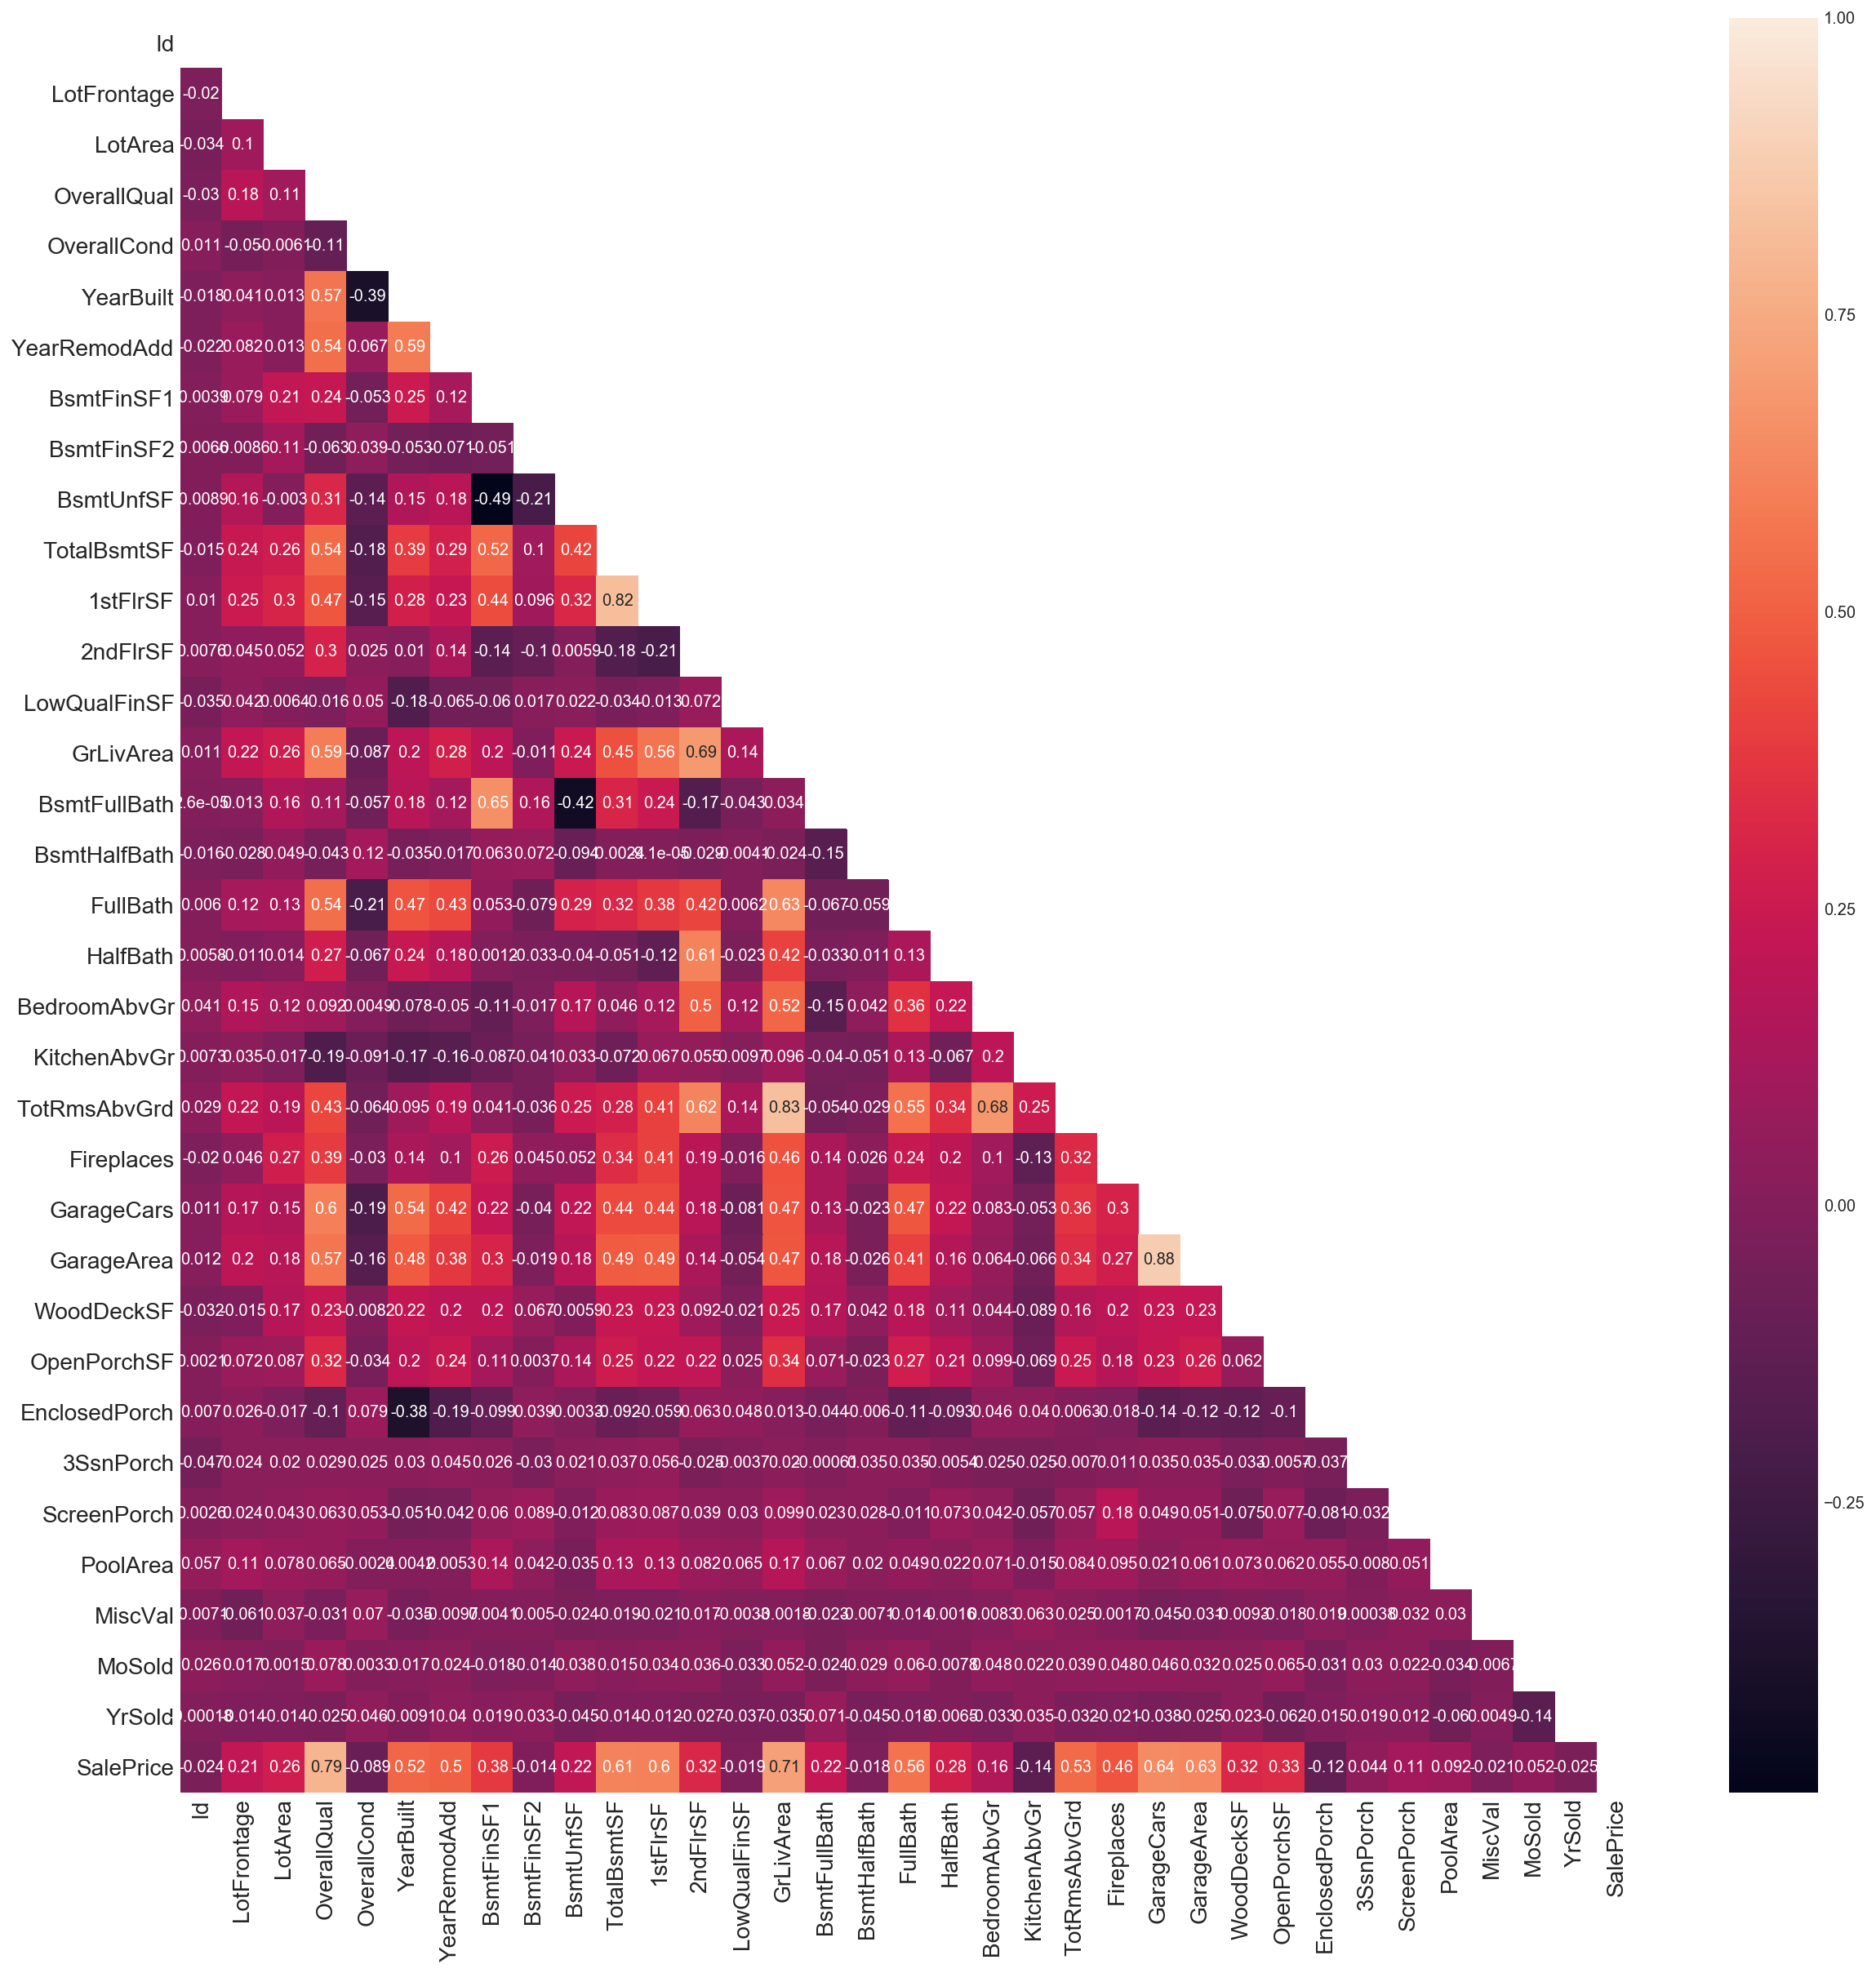

In [39]:
#sns.heatmap(residential.corr())

corrmap = residential.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrmap, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrmap, mask=mask, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.show()

#### From the heatmap: GrLivArea is our top candidate.

In [40]:
# Find most important features relative to target
print("Top Correlations to SalePrice")
corr = residential.corr()
corr.sort_values('SalePrice', ascending = False, inplace = True)
corr.SalePrice.head(20) ## Top 20

Top Correlations to SalePrice


SalePrice       1.000000
OverallQual     0.789031
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
1stFlrSF        0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
YearRemodAdd    0.501186
Fireplaces      0.463264
BsmtFinSF1      0.384475
OpenPorchSF     0.329491
WoodDeckSF      0.320770
2ndFlrSF        0.319774
HalfBath        0.280882
LotArea         0.264715
BsmtFullBath    0.224054
BsmtUnfSF       0.216152
Name: SalePrice, dtype: float64

### SalePrice Distribution

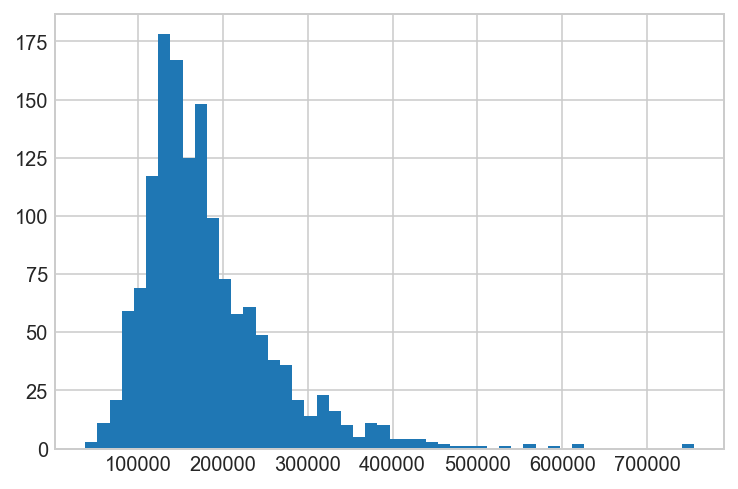

In [41]:
## See Distributions
residential.SalePrice.hist(bins=50)

## Skewed right, not sure if theres any use for us to log.

### OverallQual and SalePrice: Lets see

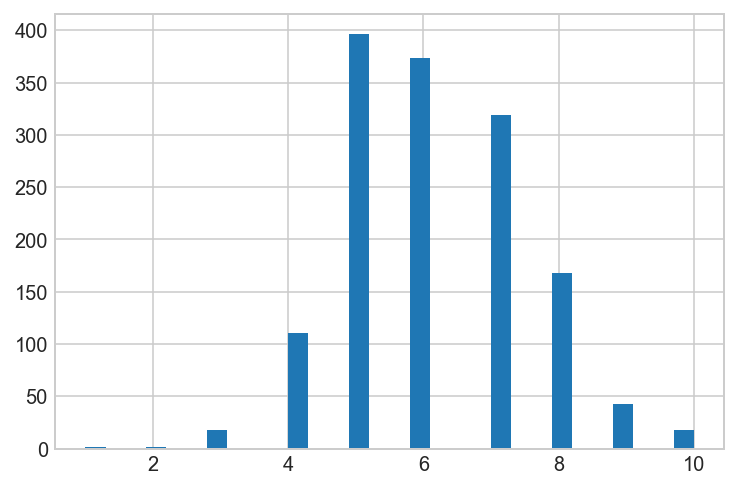

In [42]:
## See Distributions for OverallQual
## OverallQual is a 'Rank' -> Was not converted to astype('str') above; as its quite indicative of the SalePrice
residential.OverallQual.hist(bins=30)

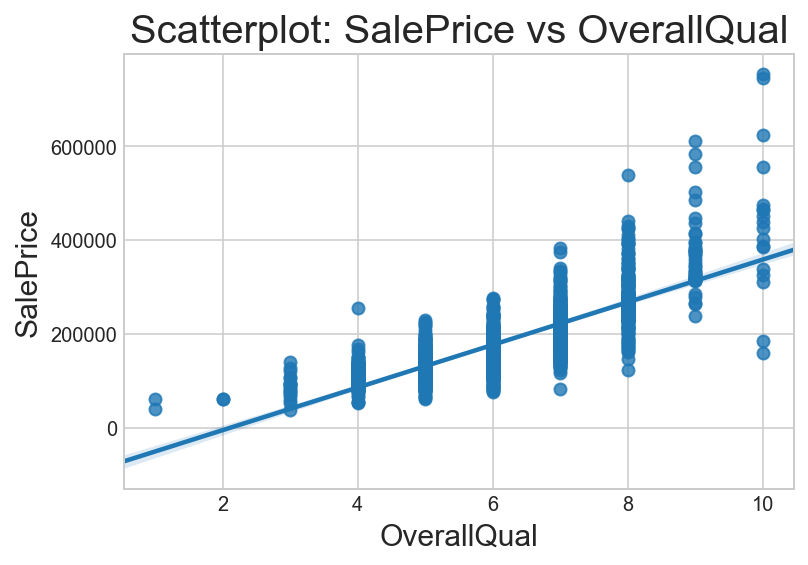

In [43]:
# ## See Scatterplot
fig, ax = plt.subplots()
## USING REGPLOT: Can see with the 'best fit' line
sns.regplot(x='OverallQual', y='SalePrice', data=residential)
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('OverallQual', fontsize=15)
plt.title('Scatterplot: SalePrice vs OverallQual', fontsize=20)
plt.show()

## Higher Quality related to Higher SalePrice! (Wow DataScience!)

### GrLivingArea and SalePrice: Lets see

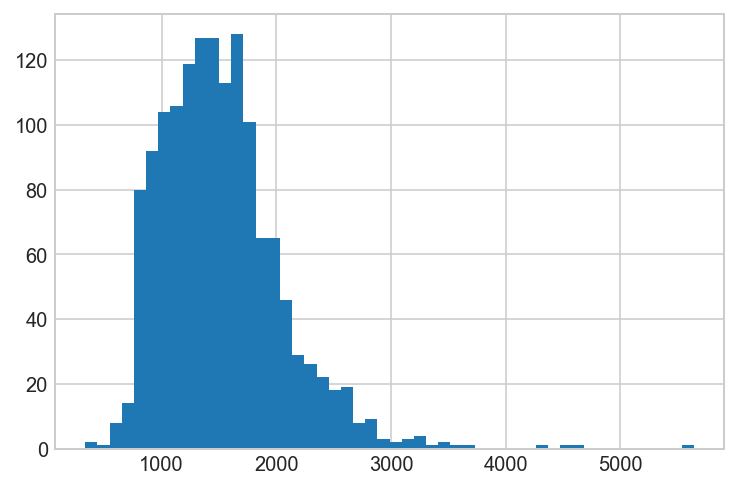

In [44]:
## See Distributions
residential.GrLivArea.hist(bins=50)

## Skewed right, not sure if theres any use for us to log.
## GrLivingArea and SalePrice have a 'similar' distribution..

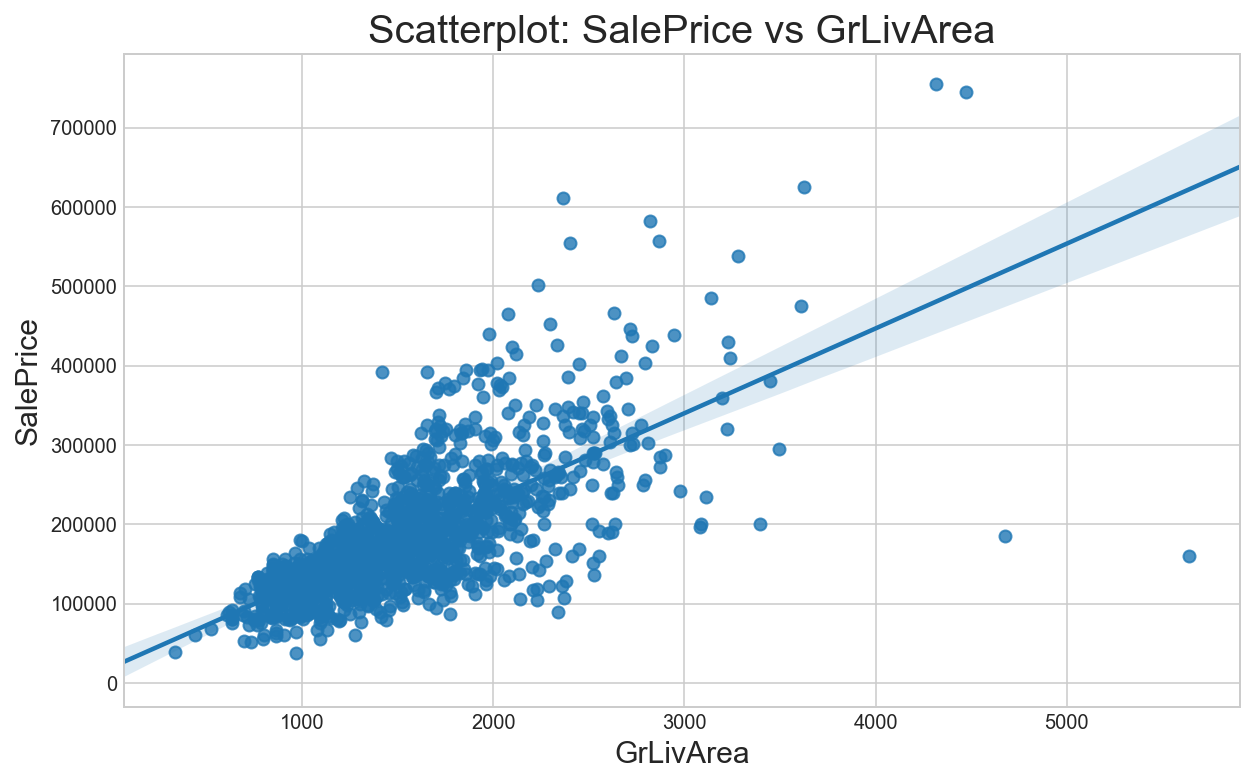

In [45]:
# ## See Scatterplot
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(x = residential['GrLivArea'], y = residential['SalePrice'])
## USING REGPLOT: Can see with the 'best fit' line
sns.regplot(x='GrLivArea', y='SalePrice', data=residential)
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.title('Scatterplot: SalePrice vs GrLivArea', fontsize=20)
plt.show()

In [46]:
### 4 Outliers: Way off the best-fit line
residential[residential.GrLivArea > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130,40094,Pave,NA,IR1,Bnk,AllPub,...,0,NA,NA,NA,0,10,2007,New,Partial,184750
691,692,60,RL,104,21535,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160,15623,Pave,NA,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NA,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313,63887,Pave,NA,IR3,Bnk,AllPub,...,480,Gd,NA,NA,0,1,2008,New,Partial,160000


In [47]:
## Drop Outliers
outliers = residential[residential.GrLivArea > 4000]

residential = residential.drop(outliers.index, axis=0)

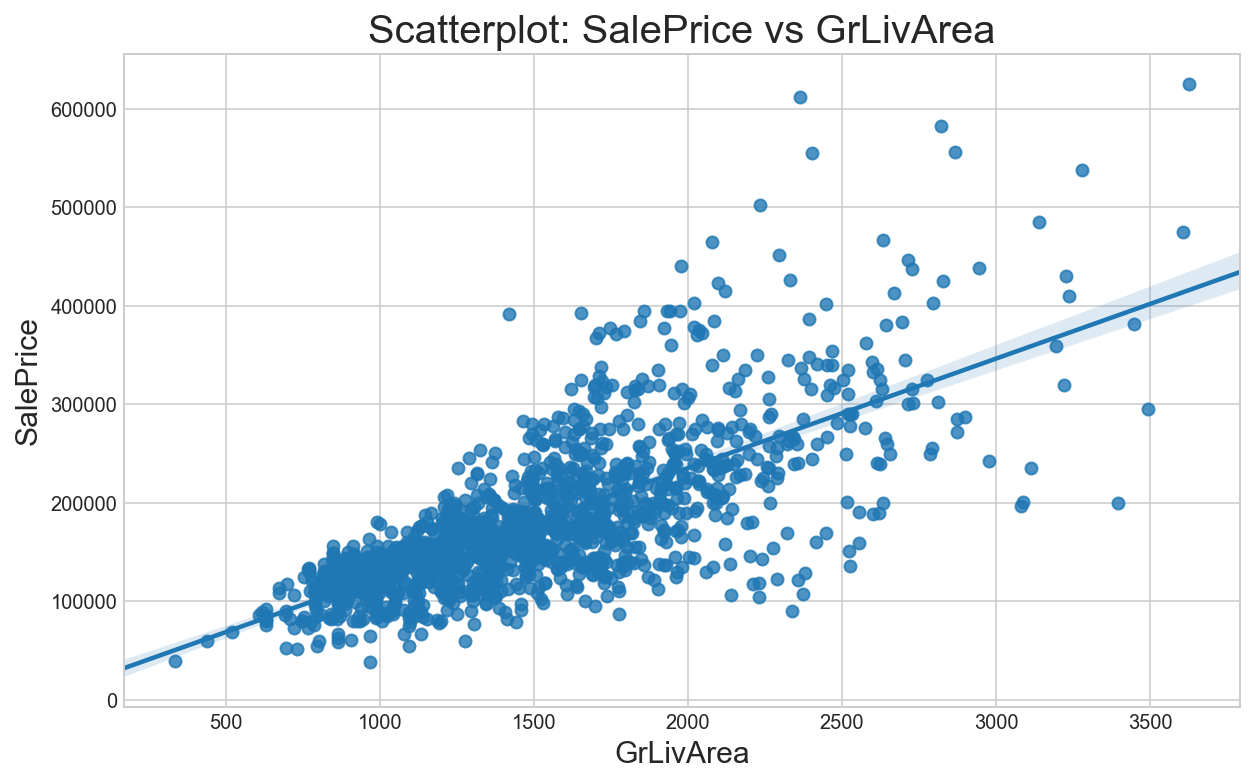

In [48]:
## Check
# ## See Scatterplot
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(x = residential['GrLivArea'], y = residential['SalePrice'])
## USING REGPLOT: Can see with the 'best fit' line
sns.regplot(x='GrLivArea', y='SalePrice', data=residential)
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.title('Scatterplot: SalePrice vs GrLivArea', fontsize=20)
plt.show()

## OK Back to building the estimator

In [49]:
# Find most important NON-CATEGORICAL features relative to target
print("Top NON-CATEGORICAL Correlations to SalePrice")
corr = residential.corr()
corr.sort_values('SalePrice', ascending = False, inplace = True)
corr.SalePrice.head(11) ## Top 10 , 11 includes SalePrice

Top NON-CATEGORICAL Correlations to SalePrice


SalePrice       1.000000
OverallQual     0.798954
GrLivArea       0.720743
GarageCars      0.651195
TotalBsmtSF     0.645274
GarageArea      0.643874
1stFlrSF        0.622735
FullBath        0.554926
TotRmsAbvGrd    0.537203
YearBuilt       0.530009
YearRemodAdd    0.515539
Name: SalePrice, dtype: float64

### List down the 'cannot be renovated' features + Justification

#### Selected from Top 10 NON-CATEGORICAL Correlations to SalePrice first.:
<ol>
<li>'OverallQual'&nbsp; - ADD : Putting this in as a 'guiding' metric. It will change due to renovation</li>
<li>'GrLivArea'&nbsp; - ADD</li>
<li>'TotalBsmtSF'&nbsp; - ADD</li>
<li>'GarageCars'&nbsp; - REMOVE</li>
<li>'GarageArea'&nbsp; - ADD</li>
<li>'1stFlrSF'&nbsp; - ADD</li>
<li>'FullBath'&nbsp; - ADD</li>
<li>'TotRmsAbvGrd'&nbsp; - REMOVE</li>
<li>'YearBuilt'&nbsp; - ADD</li>
<li>'YearRemodAdd'&nbsp; - ADD</li>

</ol>


#### Selected from Description by Intuition, then remove Non-Renovatable:
<ol>
<li>LotArea: Lot size in square feet.&nbsp; - ADD</li>
<li>Alley: Type of alley access to property&nbsp;- REMOVE</li>
<li>Utilities: Type of utilities available&nbsp; - REMOVE</li>
<li>LotConfig: Lot configuration&nbsp;- REMOVE</li>
<li>Neighborhood: Physical locations within Ames city limits&nbsp; - ADD</li>
<li>BldgType: Type of dwelling&nbsp; - ADD</li>
<li>OverallQual: Rates the overall material and finish of the house&nbsp; - ADDED ALREADY</li>
<li>OverallCond: Rates the overall condition of the house&nbsp; - ADD</li>
<li>YearBuilt: Original construction date&nbsp; - ADDED ALREADY</li>
<li>YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)&nbsp; -  ADDED ALREADY</li>
<li>CentralAir: Central air conditioning&nbsp; - REMOVE</li>
<li>PoolQC: PoolQC: Pool quality&nbsp; - REMOVE</li>
<li>BsmtQual: Evaluates the height of the basement&nbsp; - ADD</li>  
<li>MiscFeature: Miscellaneous feature not covered in other categories&nbsp; - REMOVE</li>
<li>SaleCondition: Condition of sale&nbsp; - <strong>NOT SURE YET. This may be a first level filter. As only Normal, AdjLand and Alloca would be indicative towards an actual market price prediction for sale price.</strong>
<ol>
<li>
<div>Normal Normal Sale</div>
</li>
<li>
<div>Abnorml Abnormal Sale - &nbsp;trade, foreclosure, short sale</div>
</li>
<li>
<div>AdjLand Adjoining Land Purchase</div>
</li>
<li>Alloca Allocation - two linked properties with separate deeds, typically condo with a garage unit
</li>
<li>
<div>Family Sale between family members</div>
</li>
<li>
<div>Partial Home was not completed when last assessed (associated with New Homes)</div>
</li>
</ol>
</li>
</ol>

In [50]:
residential.SaleCondition.value_counts()

## Remove Partial + Abnormal + Family = 125+96+20= 241 rows.. Can i afford to drop??

## PUT ON HOLD FIRST

Normal     1193
Partial     123
Abnorml      95
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [51]:
no_reno_features_noncat = ['OverallQual',
                            'GrLivArea',
                            'TotalBsmtSF',
                            'GarageArea',
                            '1stFlrSF',
                            'FullBath',
                            'YearBuilt',
                            'YearRemodAdd',
                            'LotArea']

## TO DUMMYOUT.
no_reno_features_cat = ['Neighborhood',
                        'BldgType',
                        'OverallCond', 
                        'BsmtQual']

## ALL Non-renovatable Features
no_reno_features = no_reno_features_noncat + no_reno_features_cat
no_reno_features

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 '1stFlrSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'LotArea',
 'Neighborhood',
 'BldgType',
 'OverallCond',
 'BsmtQual']

# Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [52]:
## Add in SalePrice and YrSold cols.
features = no_reno_features + ['YrSold','SalePrice']

In [53]:
## TRAININGDATA from Residential
TRAININGDATA = residential[features].copy()

## Dummy out
TRAININGDATA = pd.get_dummies(TRAININGDATA, columns=no_reno_features_cat, drop_first=True)

print TRAININGDATA.shape
##SPLIT THE DATA INTO < 2010 AND == 2010
TESTSET = TRAININGDATA[TRAININGDATA.YrSold == 2010].copy()
TRAINSET = TRAININGDATA[TRAININGDATA.YrSold < 2010].copy()

(1446, 51)


In [54]:
## YrSold served is Purpose, we can drop it.
TESTSET.drop('YrSold', axis=1, inplace=True)
TRAINSET.drop('YrSold', axis=1, inplace=True)

In [55]:
TESTSET.shape

(172, 50)

In [56]:
TRAINSET.shape

(1274, 50)

In [57]:
ss = StandardScaler()

In [58]:
## TRAINING SET
X_train = TRAINSET.drop('SalePrice', axis=1)
X_train = ss.fit_transform(X_train) ##Standardize
y_train = TRAINSET['SalePrice'].values

## TESTING SET
X_test = TESTSET.drop('SalePrice', axis=1)
X_test = ss.fit_transform(X_test) ##Standardize
y_test = TESTSET['SalePrice'].values

## Build Model

### Base LinearRegression cv=15

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [89]:
linreg_scores = cross_val_score(model, X_test, y_test, cv=15)

#print linreg_scores
print('CV-ed Base Test LinearRegression R2 score: {}'.format(np.mean(linreg_scores)))


CV-ed Base Test LinearRegression R2 score: -1.11279339473e+22


#### R2 Doesn't look good... 

### RidgeCV cv=15

In [61]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=15)
optimal_ridge.fit(X_train, y_train)

print('Optimal alpha: {}'.format(optimal_ridge.alpha_))

Optimal alpha: 20.2358964773


### Ridge with optimal_alpha cv=15

In [62]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=15)

#print ridge_scores
print('Ridge R2 score: {}'.format(np.mean(ridge_scores)))

Ridge R2 score: 0.876359614149


In [63]:
# It's vastly better than the linear regression. 
# There's likely so much multicollinearity in the data that linear regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

### LassoCV cv=15

In [64]:
optimal_lasso = LassoCV(n_alphas=500, cv=15, verbose=1)
optimal_lasso.fit(X_train, y_train)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

189.40643271650663


.........................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.3s finished


###  Lasso with optimal_alpha cv=15

In [65]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=15)

#print lasso_scores
print('Lasso R2 score: {}'.format(np.mean(lasso_scores)))

Lasso R2 score: 0.877043400006


### Lets try ElasticNet cv=15

In [66]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=15,
                            verbose=1)
optimal_enet.fit(X_train, y_train)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

200.28578733369778
1.0


........................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:    2.3s finished


In [67]:
## The L1 Ratio is 1.0 = LASSO
## Lets see with the optimals
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=15)

print enet_scores
print np.mean(enet_scores)

[0.9103882  0.85970555 0.91183971 0.91861604 0.89024129 0.88035668
 0.87996196 0.85768433 0.87592078 0.84963037 0.90300153 0.85047704
 0.85881327 0.82198255 0.88731164]
0.8770620636563553


### Seems to be telling me to go full Lasso

In [68]:
## Plot to see the Residuals
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=189.40643271650663, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [69]:
# Model residuals:
ridge_resid = y_test - ridge.predict(X_test)
lasso_resid = y_test - lasso.predict(X_test)

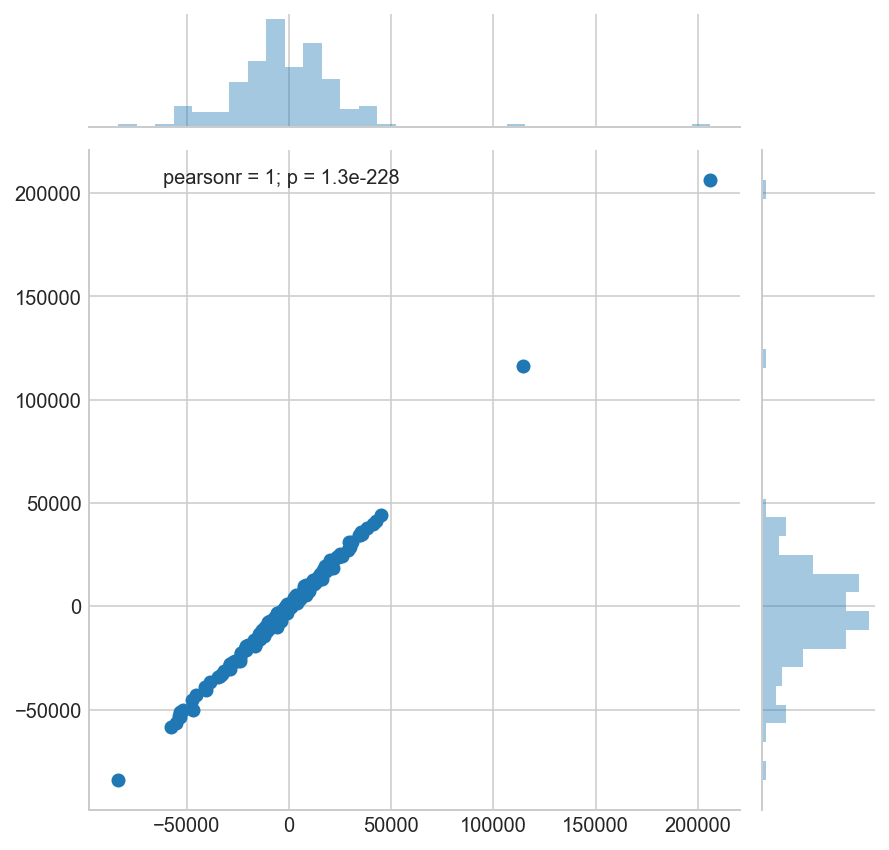

In [70]:
sns.jointplot(ridge_resid, lasso_resid)

## Both seem normally distributed..and quite linear..

###  Lets go with Lasso

In [71]:
lasso.fit(X_train, y_train)

Lasso(alpha=189.40643271650663, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [72]:
lasso_coefs = pd.DataFrame({'variable':TRAINSET.drop('SalePrice', axis=1).columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,abs_coef,coef,variable
1,25814.961365,25814.961365,GrLivArea
48,18849.087754,-18849.087754,BsmtQual_TA
46,17980.188942,-17980.188942,BsmtQual_Gd
0,16030.558528,16030.558528,OverallQual
6,13869.168492,13869.168492,YearBuilt
2,13813.130212,13813.130212,TotalBsmtSF
24,7442.673803,7442.673803,Neighborhood_NridgHt
8,6820.134829,6820.134829,LotArea
30,6315.407656,6315.407656,Neighborhood_StoneBr
3,5889.090356,5889.090356,GarageArea


In [73]:
print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))

Percent variables zeroed out: 0.16326530612244897


## REVISIT LinearRegression only using Lasso's non-zero features.

In [74]:
lasso_selected_feat = lasso_coefs[lasso_coefs.abs_coef != 0]['variable'].tolist()

In [75]:
## Add in SalePrice and YrSold cols.
features_v2 = lasso_selected_feat + ['YrSold','SalePrice']

In [76]:
## TRAININGDATA2 from TRAININGDATA
## (Reminder: TRAININGDATA IS ALREADY DUMMIED. EVERYTHING WAS DONE WITH DUMMIED OUT COLS)
TRAININGDATA2 = TRAININGDATA[features_v2].copy()

##SPLIT THE DATA INTO < 2010 AND == 2010
TESTSET2 = TRAININGDATA2[TRAININGDATA2.YrSold == 2010].copy()
TRAINSET2 = TRAININGDATA2[TRAININGDATA2.YrSold < 2010].copy()

In [77]:
## YrSold served is Purpose, we can drop it.
TESTSET2.drop('YrSold', axis=1, inplace=True)
TRAINSET2.drop('YrSold', axis=1, inplace=True)

### TRAINSET2 & TESTSET2 !

In [78]:
## TRAINING SET 2
X_train2 = TRAINSET2.drop('SalePrice', axis=1)
X_train2 = ss.fit_transform(X_train2) ##Standardize
y_train2 = TRAINSET2['SalePrice'].values

## TESTING SET 2
X_test2 = TESTSET2.drop('SalePrice', axis=1)
X_test2 = ss.fit_transform(X_test2) ##Standardize
y_test2 = TESTSET2['SalePrice'].values

In [79]:
model2 = LinearRegression()
model2.fit(X_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
linreg_scores2 = cross_val_score(model2, X_test2, y_test2, cv=9) 
#print linreg_scores
print('LinearRegression with select features after Lasso: R2 score: {}'.format(np.mean(linreg_scores2)))

LinearRegression with select features after Lasso: R2 score: 0.780867789767


## Lets try it out

### Lets Predict with X_test2! on model2 !

In [81]:
## Keep fingers crossed.
y_pred = model2.predict(X_test2)

In [82]:
print('Mean squared error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Model Score R2: {}'.format(model2.score(X_test2, y_test2)))
print('Cross Validated R2: {}'.format(np.mean(cross_val_score(model2, X_test2,y_test2, cv=9))))

Mean squared error: 812652196.724
Model Score R2: 0.872172222687
Cross Validated R2: 0.780867789767


### Seems good to go!

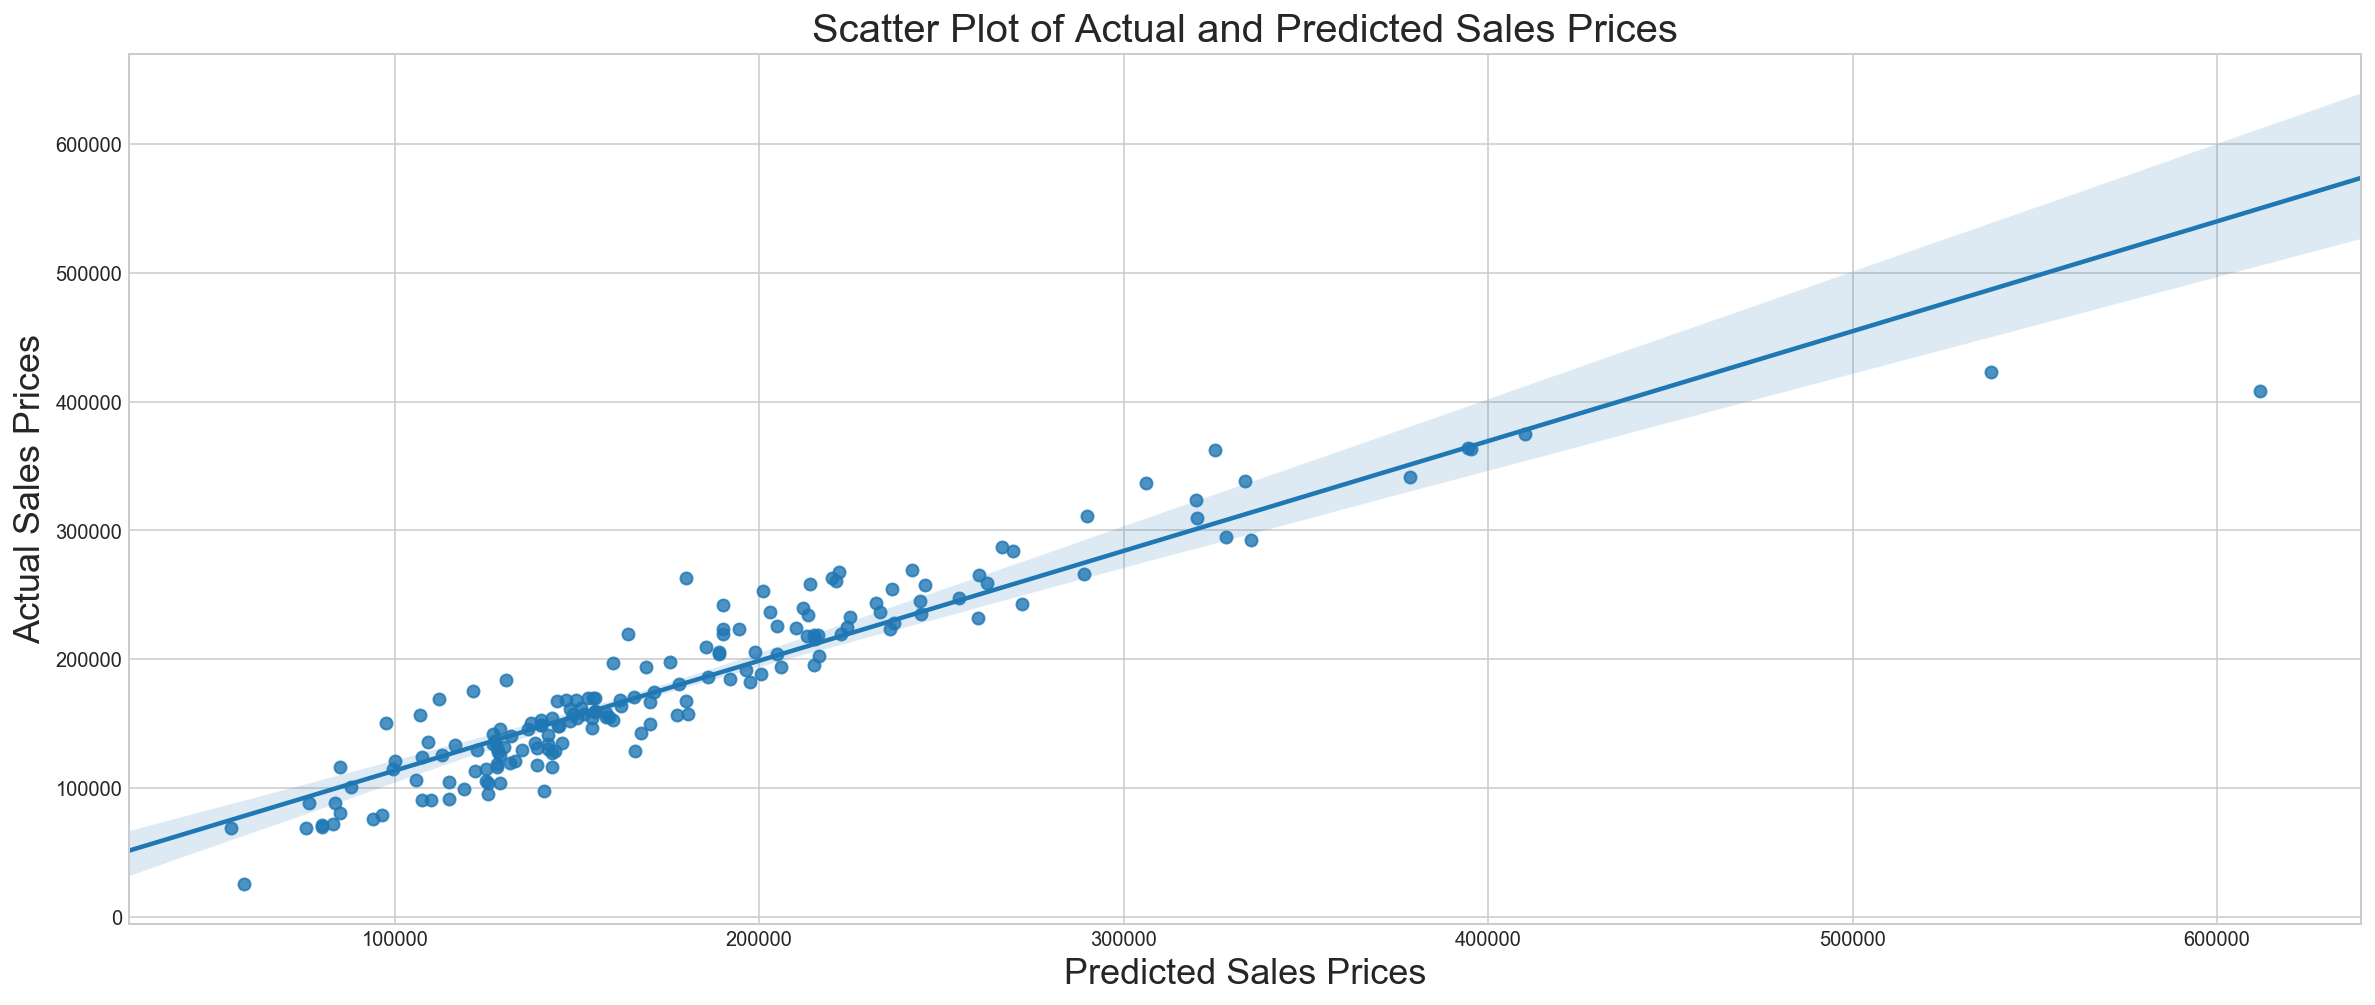

In [83]:
# Plot Actual vs Predicted SalesPrice
plt.figure(figsize=(20,8))
sns.regplot(y_test, y_pred, fit_reg=True)

plt.title('Scatter Plot of Actual and Predicted Sales Prices', fontsize=20)
plt.xlabel('Predicted Sales Prices', fontsize=18)
plt.ylabel('Actual Sales Prices', fontsize=18)
plt.show()

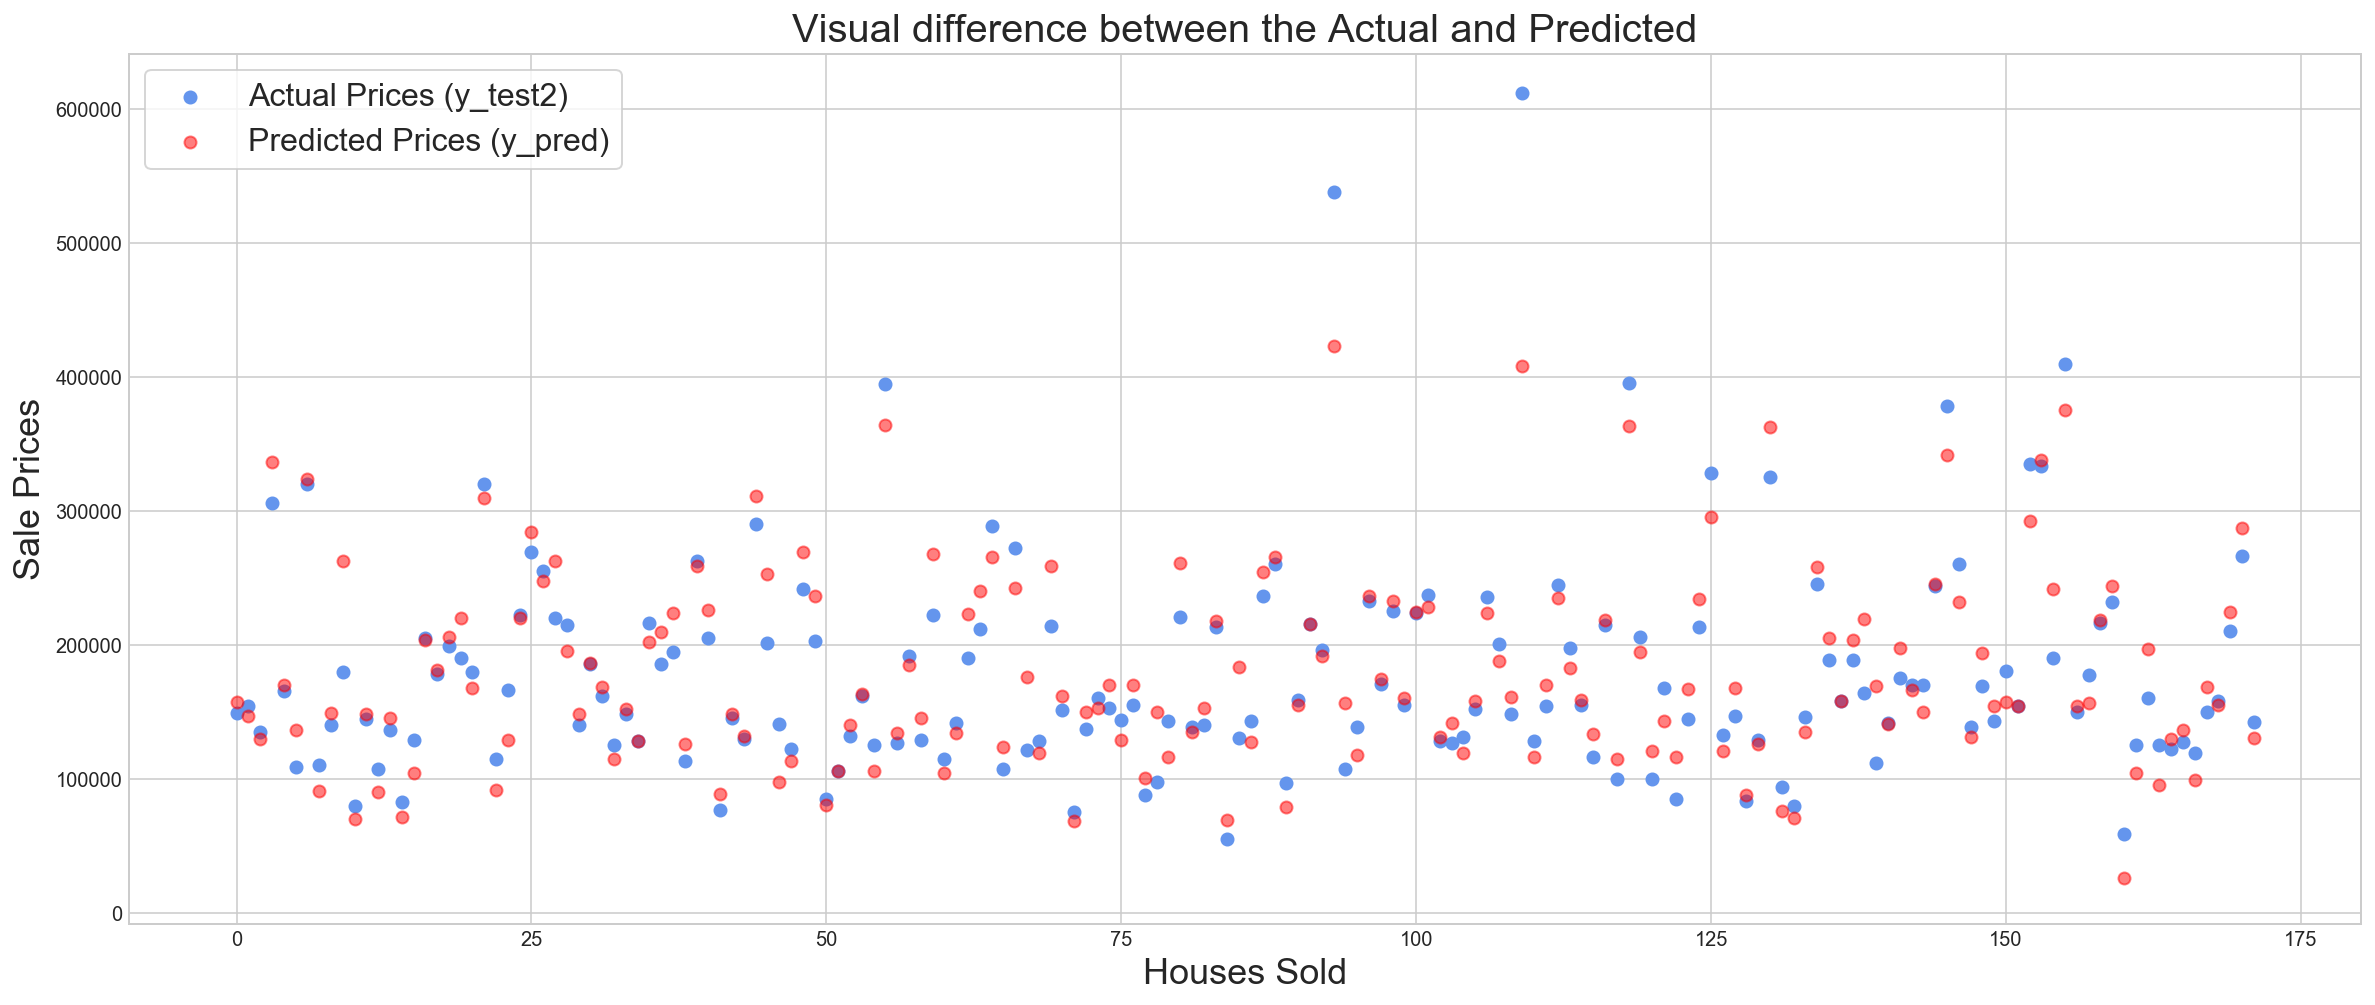

In [84]:
# Plot the Actual(y_test2) and Predicted (y_pred)
# BLUE = Actual (y_test2)
# RED =  Predicted (y_pred)

plt.figure(figsize=(20,8))
plt.scatter(range(len(y_test2)), y_test2,  color='cornflowerblue', label='Actual Prices (y_test2)') #Actual (y_test2)
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted Prices (y_pred)') #Predicted (y_pred)

plt.legend(loc='upper left', prop={'size': 16}, frameon=True)

plt.title('Visual difference between the Actual and Predicted', fontsize=20)
plt.xlabel('Houses Sold', fontsize=18)
plt.ylabel('Sale Prices', fontsize=18)
plt.show()

In [85]:
#TRAINSET2[TRAINSET2.SalePrice > 500000]

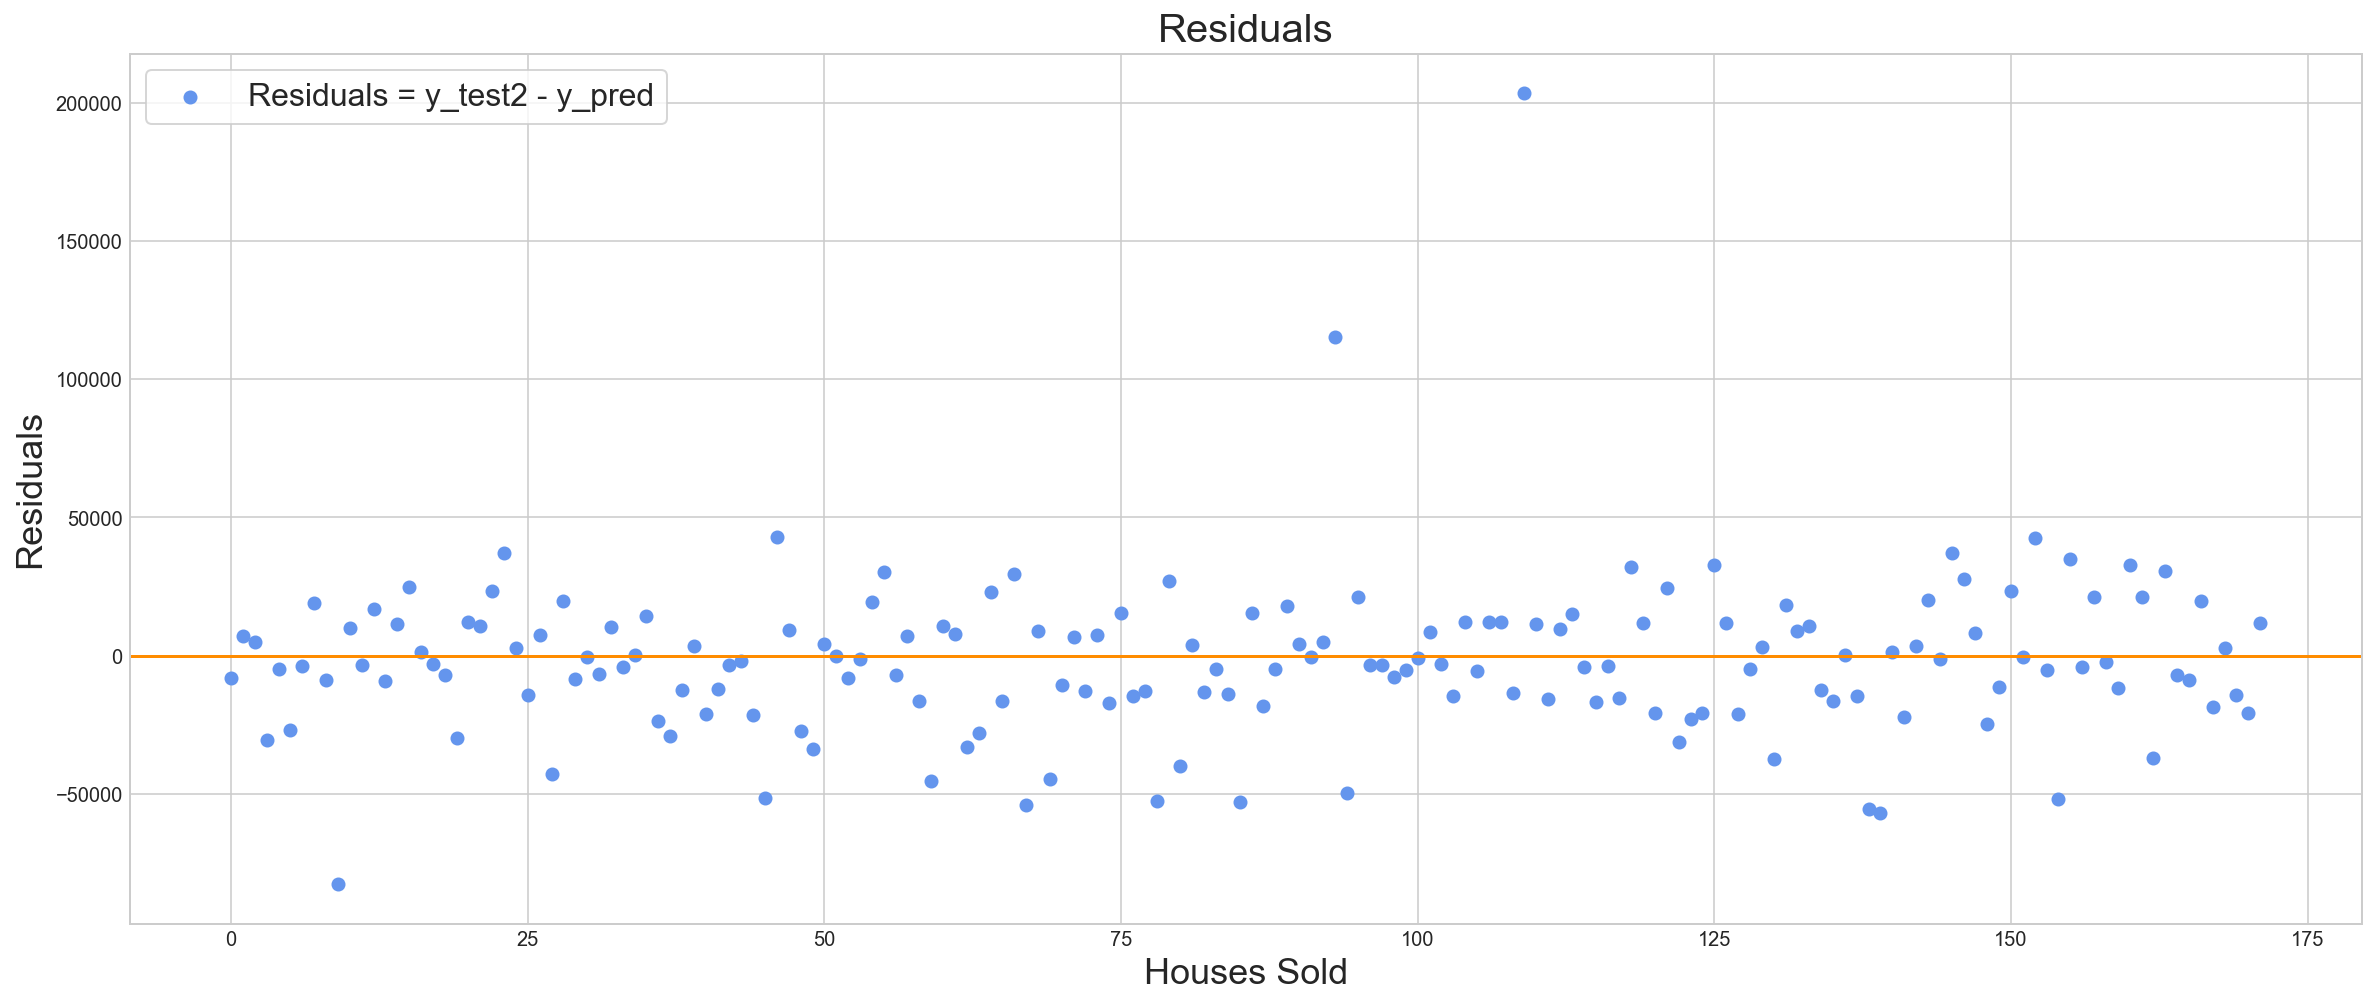

In [86]:
# Plot the Residuals = y_test2 - y_pred
Residuals = y_test2 - y_pred

plt.figure(figsize=(20,8))
plt.scatter(range(len(Residuals)), Residuals,  color='cornflowerblue', label='Residuals = y_test2 - y_pred') #Residuals
#plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted Prices (y_pred)') #Predicted (y_pred)

plt.legend(loc='upper left', prop={'size': 16}, frameon=True)

plt.title('Residuals', fontsize=20)
plt.xlabel('Houses Sold', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.axhline(y=0, color='darkorange')  ## the 0 line to see how far the residuals are.
plt.show()

### The LinearRegression model: model2 is ready to be used.
### Please np.exp the predictions.
#### Might investigate why the 2 outliers are up there..but for now.. Moving on..

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [87]:
no_reno_features_noncat = ['OverallQual',
                            'GrLivArea',
                            'TotalBsmtSF',
                            'GarageArea',
                            '1stFlrSF',
                            'FullBath',
                            'YearBuilt',
                            'YearRemodAdd',
                            'LotArea']

## TO DUMMYOUT.
no_reno_features_cat = ['Neighborhood',
                        'BldgType',
                        'OverallCond', 
                        'BsmtQual']

## ALL Non-renovatable Features
no_reno_features = no_reno_features_noncat + no_reno_features_cat
no_reno_features

residential.select_dtypes(include=['object']).columns

Index([u'MSSubClass', u'MSZoning', u'Street', u'Alley', u'LotShape',
       u'LandContour', u'Utilities', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'RoofStyle', u'RoofMatl', u'Exterior1st',
       u'Exterior2nd', u'MasVnrType', u'MasVnrArea', u'ExterQual',
       u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'KitchenQual', u'Functional',
       u'FireplaceQu', u'GarageType', u'GarageYrBlt', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [88]:
# A: